In [1]:
# MONAI Dual-Task (Segmentation + Classification) training using nnU-Net-style pipeline
# - Dataset: derived/unified_dualtask (train/val/test CSVs)
# - Spacing standardization to (0.8, 0.8, 1.0) mm
# - Label-preserving resample via one-hot + optional dilate-then-erode
# - Sliding-window patch training (192x192x160)
# - Shared-encoder segmentation (DynUNet) + classification head
# - QC counters that flag label shrinkage post-resample

import os, math, time, json, random, csv, hashlib, platform, subprocess
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
import nibabel as nib

from monai.config import print_config
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.inferers import SlidingWindowInferer
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import DynUNet
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    RandFlipd,
    RandRotate90d,
    RandAffined,
    AsDiscreted,
    CastToTyped,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.6.dev2533
Numpy version: 2.3.2
Pytorch version: 2.8.0+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d7a3eeb01a4d660d5fe25ed186117499aa57466e
MONAI __file__: /home/<username>/projects/brain_tumor_segmentation/venv-monai/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.1
Pillow version: 11.3.0
Tensorboard version: 2.20.0
gdown version: 5.2.0
TorchVision version: 0.23.0+cu128
tqdm version: 4.67.1
lmdb version: 1.7.3
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 3.2.0
pynrrd version: 1.1.3
clearml version: 2.0.3rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# Reproducibility
SEED = 42
set_determinism(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    try:
        gpu_name = torch.cuda.get_device_name(0)
    except Exception:
        gpu_name = "Unknown CUDA device"
    print(f"Device: {device} ({gpu_name})")
else:
    print(f"Device: {device}")

# Paths
PROJ_ROOT = Path("/home/ant/projects/brain_tumor_segmentation")
DUALTASK_ROOT = PROJ_ROOT / "derived" / "unified_dualtask"
TRAIN_CSV = DUALTASK_ROOT / "train.csv"
VAL_CSV = DUALTASK_ROOT / "val.csv"
TEST_CSV = DUALTASK_ROOT / "test.csv"

# Basic path checks with clear messages
missing = [p for p in [DUALTASK_ROOT, TRAIN_CSV, VAL_CSV, TEST_CSV] if not p.exists()]
assert not missing, f"Missing required paths: {', '.join(str(p) for p in missing)}"

# Target spacing and patch params
TARGET_SPACING = (0.8, 0.8, 1.0)
PATCH_SIZE = (192, 192, 160)
PATCH_OVERLAP = 0.5  # sliding window overlap

# Checkpoint directory
ckpt_dir = PROJ_ROOT / "runs" / "dualtask_monai_v01"
ckpt_dir.mkdir(parents=True, exist_ok=True)
print("Checkpoint dir:", ckpt_dir)

Device: cuda (NVIDIA RTX A6000)
Checkpoint dir: /home/ant/projects/brain_tumor_segmentation/runs/dualtask_monai_v01


In [3]:
# Run/session paths and lightweight CSV helper

RUN_ID = datetime.now().strftime("%Y%m%d-%H%M%S")
RUN_DIR = ckpt_dir / RUN_ID
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Common artifact paths for this run
METRICS_CSV = RUN_DIR / "metrics.csv"
CONFIG_JSON = RUN_DIR / "config.json"
ENV_JSON = RUN_DIR / "env.json"
QC_CSV = RUN_DIR / "qc_epoch_summary.csv"

def write_csv_header(path: Path, header: List[str]):
    """
    Open a CSV for appending and write the header if the file doesn't exist yet.
    Returns (file_handle, csv_writer). Caller is responsible for closing the file_handle.
    """
    is_new = not path.exists()
    f = open(path, "a", newline="")
    w = csv.writer(f)
    if is_new:
        w.writerow(header)
        f.flush()
        os.fsync(f.fileno())
    return f, w

In [4]:
# CSV → list[dict] helpers with validation

from typing import Any

def read_unified_csv(path: Path, check_files: bool = True) -> List[Dict[str, Any]]:
    df = pd.read_csv(path)
    expected_cols = {"case_id", "class_label", "image_path", "label_path"}
    missing = expected_cols - set(df.columns)
    assert not missing, f"Missing columns in {path.name}: {sorted(missing)}"

    # Clean and coerce types
    df = df.copy()
    df["case_id"] = df["case_id"].astype(str).str.strip()
    df["image_path"] = df["image_path"].astype(str).str.strip()
    df["label_path"] = df["label_path"].astype(str).str.strip()
    df["class_label"] = pd.to_numeric(df["class_label"], errors="coerce").fillna(-1).astype(int)

    # Optional: drop rows whose files don’t exist
    if check_files:
        def exists(p: str) -> bool: return Path(p).exists()
        bad_mask = (~df["image_path"].map(exists)) | (~df["label_path"].map(exists))
        if bad_mask.any():
            n_bad = int(bad_mask.sum())
            print(f"[WARN] {n_bad} rows dropped from {path.name} due to missing files")
            df = df.loc[~bad_mask]

    # Build MONAI-style dicts
    items: List[Dict[str, Any]] = [
        {
            "case_id": r["case_id"],
            "image": r["image_path"],
            "label": r["label_path"],
            "class_label": int(r["class_label"]),
        }
        for _, r in df.iterrows()
    ]
    return items

train_items = read_unified_csv(TRAIN_CSV)
val_items = read_unified_csv(VAL_CSV)
test_items = read_unified_csv(TEST_CSV)

len(train_items), len(val_items), len(test_items)

(972, 209, 207)

In [ ]:
# # Only run this cell to get data for testing the training pipeline
# # This is not part of the training pipeline

# import random
# random.seed(SEED)

# def stratified_take(items, n_per_class):
#     by_c = {0: [], 1: []}
#     for it in items:
#         by_c[it["class_label"]].append(it)
#     for k in by_c: random.shuffle(by_c[k])
#     out = []
#     for k in by_c:
#         out.extend(by_c[k][:n_per_class.get(k, 0)])
#     random.shuffle(out)
#     return out

# # e.g., if you want roughly balanced splits (adjust counts if class distribution is skewed)
# train_items = stratified_take(train_items, {0:10, 1:10})  # total 20
# val_items   = stratified_take(val_items,   {0:3,  1:2 })  # total 5
# test_items  = stratified_take(test_items,  {0:3,  1:2 })  # total 5

In [5]:
# Morphology utilities and QC counters
import scipy.ndimage as ndi
from typing import Optional, List, Tuple

class LabelQC:
    """
    Tracks label shrinkage across patches/cases.
    - shrink_warn_threshold: fraction of volume lost (e.g., 0.35 → warn if after < 65% of before)
    - verbose: if True, prints a line for each warning
    """
    def __init__(self, shrink_warn_threshold: float = 0.35, verbose: bool = True):
        self.shrink_warn_threshold = float(shrink_warn_threshold)
        self.verbose = bool(verbose)
        self.total: int = 0
        self.warn: int = 0
        self.flagged_examples: List[Tuple[str, int, int, float]] = []  # (case_id, before, after, ratio)

    def reset(self) -> None:
        self.total = 0
        self.warn = 0
        self.flagged_examples.clear()

    @property
    def rate(self) -> float:
        return self.warn / max(1, self.total)

    def update(self, before_voxels: int, after_voxels: int, case_id: str) -> None:
        self.total += 1
        if before_voxels <= 0:
            return
        ratio = (after_voxels + 1e-6) / (before_voxels + 1e-6)
        if ratio < (1.0 - self.shrink_warn_threshold):
            self.warn += 1
            self.flagged_examples.append((case_id, int(before_voxels), int(after_voxels), float(ratio)))
            if self.verbose:
                print(f"[QC] label shrinkage: {case_id} before={before_voxels} after={after_voxels} ratio={ratio:.3f}")

    def summary(self) -> None:
        print(f"[QC] shrinkage warnings: {self.warn}/{self.total} (rate={self.rate:.4f})")

def binary_dilate_then_erode(mask: np.ndarray, radius_vox: int = 1, connectivity: int = 1) -> np.ndarray:
    """
    Light morphological close (dilate then erode) to protect thin/fragmented labels.
    - mask: 3D array (D,H,W). Nonzeros are treated as foreground.
    - radius_vox: number of iterations for dilation and erosion. 0 → no-op.
    - connectivity: 1 (faces), 2 (faces+edges), or 3 (faces+edges+corners).
    Returns uint8 mask (0/1).
    """
    if radius_vox <= 0:
        return (mask > 0).astype(np.uint8)
    if mask.ndim != 3:
        raise ValueError(f"Expected 3D mask, got shape {mask.shape}")

    mask_bool = (mask > 0)
    structure = ndi.generate_binary_structure(rank=3, connectivity=int(connectivity))
    dil = ndi.binary_dilation(mask_bool, structure=structure, iterations=int(radius_vox))
    ero = ndi.binary_erosion(dil, structure=structure, iterations=int(radius_vox))
    return ero.astype(np.uint8)

In [6]:
# Transforms: spacing standardization and intensity scale
# Labels: post-process after Spacingd to preserve small lesions (no extra soft resampling)

from monai.transforms import MapTransform

class LabelPostProcessd(MapTransform):
    """
    - Ensures label shape matches image shape (nearest-neighbor up/down-sample if needed)
    - Optional light morphology (dilate→erode) to protect thin/speck lesions
    - Records QC counts: qc_before_vox, qc_after_vox
    """
    def __init__(self, keys, ref_key: str = "image", morph_radius: int = 1, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.ref_key = ref_key
        self.morph_radius = int(morph_radius)

    def __call__(self, data):
        d = dict(data)
        if "label" not in d:
            return d

        label = d["label"]  # Tensor [1, D, H, W]
        img = d.get(self.ref_key, None)
        before_vox = int((label > 0).sum().item())

        # Match label to image grid if needed (nearest to avoid smoothing)
        if img is not None and label.shape[1:] != img.shape[1:]:
            label = torch.nn.functional.interpolate(
                label.float(), size=img.shape[1:], mode="nearest"
            ).long()

        # Optional light morphology
        if self.morph_radius > 0:
            arr = (label > 0).cpu().numpy().astype(np.uint8)  # [1, D, H, W]
            arr = binary_dilate_then_erode(arr[0], radius_vox=self.morph_radius)[None]  # back to [1, ...]
            label = torch.as_tensor(arr, dtype=torch.long, device=d["label"].device)

        after_vox = int((label > 0).sum().item())

        d["label"] = label
        d["qc_before_vox"] = before_vox
        d["qc_after_vox"] = after_vox
        return d


# Common I/O and spacing (labels via nearest to avoid smoothing)
common_load = [
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=TARGET_SPACING, mode=("bilinear", "nearest")),
]

from monai.transforms import RandCropByPosNegLabeld, SpatialPadd

# Training intensity + spatial augs
intensity_train = [
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    RandFlipd(keys=["image", "label"], spatial_axis=[0, 1, 2], prob=0.2),
    RandRotate90d(keys=["image", "label"], prob=0.2, max_k=3),
    RandAffined(
        keys=["image", "label"],
        rotate_range=(math.pi/36, math.pi/36, math.pi/36),
        scale_range=(0.1, 0.1, 0.1),
        mode=("bilinear", "nearest"),
        prob=0.2,
    ),
    SpatialPadd(keys=["image", "label"], spatial_size=PATCH_SIZE),
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=PATCH_SIZE,
        pos=1, neg=1, num_samples=1, image_key="image",
        allow_smaller=True,
    ),
]

# Validation intensity only
intensity_val = [
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
]

# Cast classification label
class CastClassLabeld(MapTransform):
    def __init__(self, keys, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
    def __call__(self, data):
        d = dict(data)
        if "class_label" in d:
            d["class_label"] = torch.as_tensor(d["class_label"], dtype=torch.float32)
        return d

# Assemble transforms
# - Post label process uses nearest resample if shapes differ (no soft one-hot resample)
# - Morph radius=1; raise to 2 if QC indicates too many tiny lesions vanish
post_label_preserve = [LabelPostProcessd(keys=["label"], ref_key="image", morph_radius=1)]

train_transforms = Compose(common_load + intensity_train + post_label_preserve + [CastClassLabeld(keys=["class_label"])])
val_transforms = Compose(common_load + intensity_val + post_label_preserve + [CastClassLabeld(keys=["class_label"])])

In [7]:
# Datasets and Loaders (with reproducible workers)

# QC accumulators (patch-level stats already added in transforms and training loop)
qc_train = LabelQC(shrink_warn_threshold=0.35, verbose=True)
qc_val = LabelQC(shrink_warn_threshold=0.35, verbose=True)

# Reproducible dataloader workers
def seed_worker(worker_id: int):
    base_seed = SEED
    np.random.seed(base_seed + worker_id)
    random.seed(base_seed + worker_id)
    torch.manual_seed(base_seed + worker_id)

use_pin = (device.type == "cuda")
g = torch.Generator()
g.manual_seed(SEED)

# Datasets (cache_rate=0.0 to avoid RAM pressure; switch to >0.0 if you want caching)
train_ds = CacheDataset(data=train_items, transform=train_transforms, cache_rate=0.0, num_workers=0)
val_ds   = CacheDataset(data=val_items,   transform=val_transforms,   cache_rate=0.0, num_workers=0)

# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    pin_memory=use_pin,
    persistent_workers=True,
    worker_init_fn=seed_worker,
    generator=g,
    prefetch_factor=2,
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=use_pin,
    persistent_workers=True,
    worker_init_fn=seed_worker,
    generator=g,
    prefetch_factor=2,
)

In [8]:
# Model: DynUNet backbone + classification head from encoder bottleneck

# Segmentation network (nnU-Net-like DynUNet)
seg_net = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    kernel_size=[3, 3, 3, 3, 3, 3],     # 6 stages
    strides=[1, 2, 2, 2, 2, 2],         # length matches kernel_size
    upsample_kernel_size=[2, 2, 2, 2, 2],
    norm_name="instance",
    deep_supervision=False,
).to(device)

# Classification head (lazy: initializes fully-connected layer on first forward)
class LazyClassificationHead(nn.Module):
    def __init__(self, num_classes: int = 1):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = None
        self.num_classes = num_classes

    def forward(self, feat: torch.Tensor) -> torch.Tensor:
        x = self.pool(feat).flatten(1)
        if self.fc is None:
            self.fc = nn.Linear(x.shape[1], self.num_classes).to(x.device)
        return self.fc(x)

cls_head = LazyClassificationHead(num_classes=1).to(device)

# Hook to capture encoder bottleneck features for classification
encoder_feat = {"x": None}
def hook_fn(module, input, output):
    encoder_feat["x"] = output

# Attach hook to a stable location in DynUNet
if hasattr(seg_net, "bottleneck"):
    seg_net.bottleneck.register_forward_hook(hook_fn)
elif hasattr(seg_net, "encoder4"):
    seg_net.encoder4.register_forward_hook(hook_fn)
else:
    print("[WARN] Could not attach hook; classification head may not receive features")

# Losses and optimizer
seg_loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
cls_loss_fn = nn.BCEWithLogitsLoss()

params = list(seg_net.parameters()) + list(cls_head.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-5, weight_decay=1e-5)

# AMP scaler
scaler = GradScaler(enabled=torch.cuda.is_available())

# Segmentation metrics
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [9]:
# Helper: pad tensor to next multiple-of factor for each spatial dim (+ safe crop helper)
import torch.nn.functional as F

def pad_to_factor(x: torch.Tensor, factor=32, return_pad: bool = False, mode: str = "constant", value: float = 0.0):
    """
    Pads a 5D tensor (B, C, D, H, W) so each spatial dim is a multiple of `factor`.
    - factor: int or (fD, fH, fW)
    - Pads only on the "right/bottom/back" to avoid shifting coordinates
    - If return_pad=True, also returns the pad tuple (Wl, Wr, Hl, Hr, Dl, Dr)
    """
    assert x.dim() == 5, f"Expected 5D tensor (B,C,D,H,W), got shape {tuple(x.shape)}"
    if isinstance(factor, int):
        fD = fH = fW = factor
    else:
        assert len(factor) == 3, "factor must be int or 3-tuple"
        fD, fH, fW = factor

    B, C, D, H, W = x.shape
    def next_m(s, f): return ((s + f - 1) // f) * f
    Dn, Hn, Wn = next_m(D, fD), next_m(H, fH), next_m(W, fW)
    pd, ph, pw = Dn - D, Hn - H, Wn - W
    pad = (0, pw, 0, ph, 0, pd)  # (W_left, W_right, H_left, H_right, D_left, D_right)

    if any(p > 0 for p in pad):
        x = F.pad(x, pad, mode=mode, value=value)

    return (x, pad) if return_pad else x

def crop_to_shape(x: torch.Tensor, shape: tuple) -> torch.Tensor:
    """
    Crops tensor x (B,C,D,H,W) to spatial shape `shape` = (D,H,W), slicing from the start along each dim.
    """
    assert x.dim() == 5 and len(shape) == 3, "x must be 5D and shape must be (D,H,W)"
    Dz, Hy, Wx = map(int, shape)
    return x[..., :Dz, :Hy, :Wx]

In [10]:
# Inferer for validation/test
inferer = SlidingWindowInferer(
    roi_size=PATCH_SIZE,
    sw_batch_size=1,
    overlap=PATCH_OVERLAP,
    mode="gaussian",
)

# Utils
from typing import Dict, Any, Tuple, Optional

def to_device(batch: Dict[str, Any], device: torch.device) -> Dict[str, Any]:
    out: Dict[str, Any] = {}
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            out[k] = v.to(device, non_blocking=True)
        else:
            out[k] = v
    return out

def sliding_infer_padded(
    images: torch.Tensor,
    network: nn.Module,
    factor: int = 32,
    target_shape: Optional[Tuple[int, int, int]] = None,
) -> torch.Tensor:
    images_p, _ = pad_to_factor(images, factor=factor, return_pad=True)
    logits = inferer(inputs=images_p, network=network)
    if target_shape is not None and logits.shape[-3:] != tuple(target_shape):
        logits = crop_to_shape(logits, target_shape)
    return logits

In [11]:
def file_sha1(path: Path | str) -> str | None:
    try:
        with open(path, "rb") as f:
            return hashlib.sha1(f.read()).hexdigest()
    except Exception:
        return None

config = {
    "run_id": RUN_ID,
    "seed": SEED,
    "device": str(device),
    "gpu_name": (torch.cuda.get_device_name(0) if torch.cuda.is_available() else None),
    "target_spacing": tuple(TARGET_SPACING),
    "patch_size": tuple(PATCH_SIZE),
    "inferer": {"roi_size": tuple(PATCH_SIZE), "overlap": float(PATCH_OVERLAP), "mode": "gaussian"},
    "model": {
        "arch": "DynUNet",
        "in_channels": 1,
        "out_channels": 2,
        "deep_supervision": False,
        "norm_name": "instance",
    },
    "loss": {"seg": "DiceCELoss", "cls": "BCEWithLogitsLoss", "cls_weight": 0.3},
    "optimizer": {
        "type": "AdamW",
        "lr": float(optimizer.param_groups[0]["lr"]),
        "weight_decay": float(optimizer.param_groups[0].get("weight_decay", 0.0)),
    },
    "augs": {
        "flip_p": 0.2, "rot90_p": 0.2,
        "affine": {"rot_deg": 5, "scale_pct": 10},
        "crop": "RandCropByPosNegLabel",
    },
    # Reflect current pipeline (nearest for labels + light morph).
    "transforms_notes": "Spacingd (image=bilinear, label=nearest), LabelPostProcessd(morph_radius=1)",
    "splits": {
        "train_csv": str(TRAIN_CSV), "val_csv": str(VAL_CSV), "test_csv": str(TEST_CSV),
        "train_csv_sha1": file_sha1(TRAIN_CSV), "val_csv_sha1": file_sha1(VAL_CSV), "test_csv_sha1": file_sha1(TEST_CSV),
    },
}

with open(CONFIG_JSON, "w") as f:
    json.dump(config, f, indent=2)
print("Saved config:", CONFIG_JSON)

Saved config: /home/ant/projects/brain_tumor_segmentation/runs/dualtask_monai_v01/20250824-081233/config.json


In [12]:
# Environment snapshot (for full reproducibility)
env = {
    "python": platform.python_version(),
    "os": platform.platform(),
    "torch": torch.__version__,
    "torch_cuda": (torch.version.cuda if torch.cuda.is_available() else None),
    "cudnn": (torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else None),
    "monai": __import__("monai").__version__,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "gpu_count": (torch.cuda.device_count() if torch.cuda.is_available() else 0),
    "gpu_name": (torch.cuda.get_device_name(0) if torch.cuda.is_available() else None),
    "seed": SEED,
}

# List all GPU names if multiple are present
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    env["gpu_names"] = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]

# Optional: exact package set (can be large)
try:
    env["pip_freeze"] = subprocess.check_output(["pip", "freeze"]).decode().splitlines()
except Exception:
    pass

with open(ENV_JSON, "w") as f:
    json.dump(env, f, indent=2)
print("Saved env:", ENV_JSON)

Saved env: /home/ant/projects/brain_tumor_segmentation/runs/dualtask_monai_v01/20250824-081233/env.json


In [13]:
# Resume (robust): prefer most recent "last.pt", otherwise fall back to "best.pt"

def find_resume_ckpt() -> Path:
    candidates = []
    # Prefer run-scoped last/best if present
    if "RUN_DIR" in globals():
        candidates += [RUN_DIR / "last.pt", RUN_DIR / "best.pt"]
    # Fallback to global dir
    candidates += [ckpt_dir / "last.pt", ckpt_dir / "best.pt"]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"No checkpoint found in {ckpt_dir} (looked for last.pt/best.pt in run/global dirs).")

RESUME_CKPT = find_resume_ckpt()
print(f"Resuming from: {RESUME_CKPT}")

# Initialize lazy cls_head.fc before loading (captures encoder channels safely)
with torch.no_grad():
    was_training = seg_net.training
    seg_net.eval()
    encoder_feat["x"] = None
    dummy = torch.zeros(1, 1, 64, 64, 64, device=device)
    _ = seg_net(dummy)
    feat = encoder_feat["x"] if encoder_feat["x"] is not None else dummy
    _ = cls_head(feat)  # initializes cls_head.fc lazily
    seg_net.train(was_training)

ckpt = torch.load(RESUME_CKPT, map_location=device)

missing, unexpected = seg_net.load_state_dict(ckpt["seg"], strict=False)
if missing or unexpected:
    print(f"[WARN] seg_net state_dict mismatches. missing={missing}, unexpected={unexpected}")
missing, unexpected = cls_head.load_state_dict(ckpt["cls"], strict=False)
if missing or unexpected:
    print(f"[WARN] cls_head state_dict mismatches. missing={missing}, unexpected={unexpected}")

if "optimizer" in ckpt:
    try:
        optimizer.load_state_dict(ckpt["optimizer"])
    except Exception as e:
        print(f"[WARN] could not load optimizer state: {e}")
if "scaler" in ckpt:
    try:
        scaler.load_state_dict(ckpt["scaler"])
    except Exception as e:
        print(f"[WARN] could not load scaler state: {e}")

# Epoch planning
start_epoch = int(ckpt.get("epoch", 0)) + 1
best_val_dice = float(ckpt.get("best_val_dice", -1.0))
EPOCHS_NEXT = 50
end_epoch = start_epoch + EPOCHS_NEXT - 1

print(f"Resuming at epoch {start_epoch} (best_val_dice={best_val_dice:.4f}); training until epoch {end_epoch}")

FileNotFoundError: No checkpoint found in /home/ant/projects/brain_tumor_segmentation/runs/dualtask_monai_v01 (looked for last.pt/best.pt in run/global dirs).

In [14]:
# Open metrics CSV (segmentation + training stats)
# Close with: metrics_f.close() at the end of training
metrics_f, metrics_w = write_csv_header(
    METRICS_CSV,
    ["epoch","split","loss","dice","acc","recall","f1","hd95","lr","seconds","qc_warns","qc_total","qc_rate"]
)

In [15]:
# Segmentation metric helpers (use with your training/validation loops)

eps = 1e-8
hd95_tr = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95)
hd95_val = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95)

def new_cm():
    return {"tp": 0, "fp": 0, "fn": 0, "tn": 0}

def update_cm(cm, ypred, ytrue):
    yp = (ypred > 0).to(torch.bool)
    yt = (ytrue > 0).to(torch.bool)
    cm["tp"] += (yp & yt).sum().item()
    cm["fp"] += (yp & ~yt).sum().item()
    cm["fn"] += (~yp & yt).sum().item()
    cm["tn"] += (~yp & ~yt).sum().item()

def cm_metrics(cm):
    tp, fp, fn, tn = cm["tp"], cm["fp"], cm["fn"], cm["tn"]
    acc = (tp + tn) / max(1, tp + fp + fn + tn)
    rec = tp / max(1, tp + fn)
    pre = tp / max(1, tp + fp)
    f1 = (2 * pre * rec) / max(eps, pre + rec)
    return acc, rec, f1

In [16]:
# Train / Val loops (refactored: correct metrics, single CSV writer, stable val Dice)

# Assumes:
# - start_epoch, end_epoch, best_val_dice defined (from resume block); if not, set them here.
# - metrics_f, metrics_w already opened by write_csv_header with header:
#   ["epoch","split","loss","dice","acc","recall","f1","hd95","lr","seconds","qc_warns","qc_total","qc_rate"]

if "start_epoch" not in globals() or "end_epoch" not in globals():
    EPOCHS = 500
    start_epoch, end_epoch = 1, EPOCHS
if "best_val_dice" not in globals():
    best_val_dice = -1.0

val_interval = 1

t0_all = time.time()
for epoch in range(start_epoch, end_epoch + 1):
    t_epoch = time.time()

    # ---- TRAIN ----
    cm_train = new_cm()
    seg_net.train(); cls_head.train()
    epoch_loss = 0.0
    num_steps = 0

    for batch in train_loader:
        # QC update per-sample (patch-level)
        for b in decollate_batch(batch):
            qc_train.update(int(b.get("qc_before_vox", 0)), int(b.get("qc_after_vox", 0)), str(b.get("case_id", "?")))
        batch = to_device(batch, device)
        images = batch["image"]
        labels = batch["label"].long()
        class_labels = batch["class_label"].view(-1, 1)

        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            # segmentation forward
            encoder_feat["x"] = None
            seg_logits = seg_net(images)                 # deep_supervision=False
            seg_logits_main = seg_logits

            # train segmentation metrics (per-batch)
            y_pred_tr = torch.argmax(torch.softmax(seg_logits_main, dim=1), dim=1, keepdim=True)
            update_cm(cm_train, y_pred_tr, labels)
            hd95_tr(y_pred_tr, labels)

            # classification forward
            feat = encoder_feat["x"] if encoder_feat["x"] is not None else seg_logits_main
            cls_logits = cls_head(feat)

            # losses
            loss_seg = seg_loss_fn(seg_logits_main, labels)
            loss_cls = cls_loss_fn(cls_logits, class_labels)
            loss = loss_seg + 0.3 * loss_cls

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        num_steps += 1

    epoch_loss /= max(1, num_steps)
    tr_acc, tr_rec, tr_f1 = cm_metrics(cm_train)
    tr_hd95 = hd95_tr.aggregate().item(); hd95_tr.reset()
    train_lr = optimizer.param_groups[0]["lr"]
    qc_rate_tr = (qc_train.warn / max(1, qc_train.total))

    print(f"Epoch {epoch}/{end_epoch} - train loss: {epoch_loss:.4f}")
    print(f"  Train: acc={tr_acc:.4f} rec={tr_rec:.4f} f1={tr_f1:.4f} hd95={tr_hd95:.2f}")
    metrics_w.writerow([
        epoch, "train",
        f"{epoch_loss:.6f}", "", f"{tr_acc:.6f}", f"{tr_rec:.6f}", f"{tr_f1:.6f}", f"{tr_hd95:.6f}",
        f"{train_lr:.6g}", f"{(time.time()-t_epoch):.2f}", qc_train.warn, qc_train.total, f"{qc_rate_tr:.4f}"
    ]); metrics_f.flush()

    # reset QC per-epoch if you prefer epoch-local stats
    qc_train.total = qc_train.warn = 0
    if epoch % val_interval == 0:
        qc_train.summary()

    # ---- VAL ----
    if epoch % val_interval == 0:
        cm_val = new_cm()
        seg_net.eval(); cls_head.eval()
        dice_metric.reset()
        val_loss = 0.0
        steps = 0
        with torch.no_grad():
            for batch in val_loader:
                for b in decollate_batch(batch):
                    qc_val.update(int(b.get("qc_before_vox", 0)), int(b.get("qc_after_vox", 0)), str(b.get("case_id", "?")))
                batch = to_device(batch, device)
                images = batch["image"]
                labels = batch["label"].long()
                class_labels = batch["class_label"].view(-1, 1)

                with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                    # padded sliding-window seg
                    images_p = pad_to_factor(images, factor=32)
                    seg_logits = inferer(inputs=images_p, network=seg_net)

                    # classification (populate encoder features on same padded grid)
                    encoder_feat["x"] = None
                    _ = seg_net(images_p)
                    if seg_logits.shape[-3:] != labels.shape[-3:]:
                        seg_logits = crop_to_shape(seg_logits, labels.shape[-3:])

                    feat = encoder_feat["x"] if encoder_feat["x"] is not None else seg_logits
                    cls_logits = cls_head(feat)

                    # per-batch seg metrics
                    y_pred = torch.argmax(torch.softmax(seg_logits, dim=1), dim=1, keepdim=True)
                    dice_metric(y_pred=y_pred, y=labels)
                    update_cm(cm_val, y_pred, labels)
                    hd95_val(y_pred, labels)

                    # per-batch val loss
                    loss_seg = seg_loss_fn(seg_logits, labels)
                    loss_cls = cls_loss_fn(cls_logits, class_labels)
                    loss = loss_seg + 0.3 * loss_cls
                val_loss += loss.item()
                steps += 1

        mean_dice = dice_metric.aggregate().item(); dice_metric.reset()
        val_loss /= max(1, steps)
        vl_acc, vl_rec, vl_f1 = cm_metrics(cm_val)
        vl_hd95 = hd95_val.aggregate().item(); hd95_val.reset()
        qc_rate_val = (qc_val.warn / max(1, qc_val.total))

        print(f"  Val loss: {val_loss:.4f} | Val Dice(tumor): {mean_dice:.4f}")
        print(f"  Val  : acc={vl_acc:.4f} rec={vl_rec:.4f} f1={vl_f1:.4f} hd95={vl_hd95:.2f}")
        qc_val.summary()

        metrics_w.writerow([
            epoch, "val",
            f"{val_loss:.6f}", f"{mean_dice:.6f}", f"{vl_acc:.6f}", f"{vl_rec:.6f}", f"{vl_f1:.6f}", f"{vl_hd95:.6f}",
            f"{train_lr:.6g}", f"{(time.time()-t_epoch):.2f}", qc_val.warn, qc_val.total, f"{qc_rate_val:.4f}"
        ]); metrics_f.flush()
        qc_val.total = qc_val.warn = 0

        # ---- Checkpointing ----
        def save_ckpt(path: Path):
            torch.save({
                "epoch": epoch,
                "seg": seg_net.state_dict(),
                "cls": cls_head.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scaler": scaler.state_dict(),
                "best_val_dice": best_val_dice,
                "config_path": str(CONFIG_JSON) if "CONFIG_JSON" in globals() else None,
                "env_path": str(ENV_JSON) if "ENV_JSON" in globals() else None,
            }, path)

        run_last = (RUN_DIR if "RUN_DIR" in globals() else ckpt_dir) / "last.pt"
        save_ckpt(run_last)

        if mean_dice > best_val_dice:
            best_val_dice = mean_dice
            run_best = (RUN_DIR if "RUN_DIR" in globals() else ckpt_dir) / "best.pt"
            save_ckpt(run_best)
            # convenience copy
            save_ckpt(ckpt_dir / "best.pt")
            print(f"  [Saved] best.pt with Dice {best_val_dice:.4f}")

        # encoder-only (save full state; downstream can load encoder subset)
        torch.save({"seg_encoder_compatible": True, "state_dict": seg_net.state_dict()},
                   (RUN_DIR if "RUN_DIR" in globals() else ckpt_dir) / "encoder_fullstate.pt")

        # Cleanup
        try:
            del images, labels, seg_logits, cls_logits, feat, y_pred
        except:
            pass
        try:
            del images_p
        except:
            pass
        torch.cuda.empty_cache()

print(f"Training done in {(time.time()-t0_all)/60:.1f} min")
# Close the metrics file (kept open for speed)
try:
    metrics_f.close()
except:
    pass

monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
the ground truth of class 0 is all 0, this may result in nan/inf distance.


[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00304-000 before=19 after=0 ratio=0.000


Num foregrounds 0, Num backgrounds 2031455, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0074_Timepoint_2 before=19 after=0 ratio=0.000
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-158-0 before=519 after=333 ratio=0.642
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00130-000 before=6 after=0 ratio=0.000
Epoch 1/500 - train loss: 0.8178
  Train: acc=0.9911 rec=0.1389 f1=0.1000 hd95=92.27
[QC] shrinkage warnings: 0/0 (rate=0.0000)


Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


  Val loss: 0.7690 | Val Dice(tumor): 0.2071
  Val  : acc=0.9968 rec=0.3058 f1=0.2450 hd95=103.58
[QC] shrinkage warnings: 0/209 (rate=0.0000)
  [Saved] best.pt with Dice 0.2071
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0213_Timepoint_3 before=9 after=1 ratio=0.111
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0076_01 before=9 after=0 ratio=0.000
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0045_Timepoint_3 before=258 after=136 ratio=0.527
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0157_Timepoint_5 before=295 after=186 ratio=0.631
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0201_Timepoint_4 before=39 after=17 ratio=0.436
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0186_Timepoint_4 before=30 after=19 ratio=0.633
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0032_Timepoint_2 before=8 after=0 ratio=0.000
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0209_Timepoint_2 before=102 after=26 ratio=0.255
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0105_Timepoint_3 before=59 a

the prediction of class 0 is all 0, this may result in nan/inf distance.


[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00371_11 before=365 after=177 ratio=0.485
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0173_Timepoint_2 before=85 after=44 ratio=0.518
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-149-0 before=3 after=0 ratio=0.000
Epoch 6/500 - train loss: 0.5577
  Train: acc=0.9969 rec=0.6988 f1=0.6071 hd95=52.30
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.6413 | Val Dice(tumor): 0.4230
  Val  : acc=0.9981 rec=0.6323 f1=0.5311 hd95=80.92
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0091_01 before=331 after=178 ratio=0.538
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0007_Timepoint_5 before=4 after=0 ratio=0.000
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00143-000 before=51 after=0 ratio=0.000
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00274_11 before=94 after=25 ratio=0.266
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-85-0 before=68 after=19 ratio=0.279
[QC] label shr

Num foregrounds 0, Num backgrounds 1874900, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0105_Timepoint_2 before=100 after=63 ratio=0.630
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0137_01 before=130 after=47 ratio=0.362
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00165-000 before=503 after=315 ratio=0.626
Epoch 271/500 - train loss: 0.1611
  Train: acc=0.9991 rec=0.8621 f1=0.8773 hd95=14.34
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2663 | Val Dice(tumor): 0.6719
  Val  : acc=0.9992 rec=0.6750 f1=0.7501 hd95=23.22
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00147_11 before=5 after=0 ratio=0.000
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00296-000 before=13 after=0 ratio=0.000
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00184-000 before=361 after=213 ratio=0.590
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0256_Timepoint_1 before=8 after=0 ratio=0.000
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00148_11 before=263 after=148 ratio=0.563
[QC] label shrinkage: BCBM_

Num foregrounds 0, Num backgrounds 1905674, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0159_Timepoint_4 before=135 after=83 ratio=0.615
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00106_11 before=26 after=0 ratio=0.000
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0041_Timepoint_2 before=338 after=211 ratio=0.624
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-158-0 before=44 after=11 ratio=0.250
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0136_01 before=61 after=0 ratio=0.000
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0018_Timepoint_2 before=17 after=0 ratio=0.000
Epoch 292/500 - train loss: 0.1593
  Train: acc=0.9992 rec=0.8613 f1=0.8783 hd95=13.65
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2810 | Val Dice(tumor): 0.6629
  Val  : acc=0.9992 rec=0.6675 f1=0.7462 hd95=26.74
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0201_Timepoint_4 before=39 after=17 ratio=0.436
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0157_Timepoint_6 before=140 after=60 ra

Num foregrounds 0, Num backgrounds 1916143, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00148_11 before=321 after=160 ratio=0.498
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00296-000 before=35 after=17 ratio=0.486
Epoch 391/500 - train loss: 0.1476
  Train: acc=0.9993 rec=0.8810 f1=0.8912 hd95=10.74
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2668 | Val Dice(tumor): 0.6634
  Val  : acc=0.9992 rec=0.7011 f1=0.7550 hd95=28.88
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0086_Timepoint_1 before=106 after=42 ratio=0.396
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00031_11 before=115 after=42 ratio=0.365
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0002_01 before=182 after=46 ratio=0.253
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-135-0 before=361 after=172 ratio=0.476
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0140_Timepoint_1 before=88 after=51 ratio=0.580
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0201_Timepoint_5 before=132 after=85 ratio=0.644
Epoc

Num foregrounds 0, Num backgrounds 2343144, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0041_Timepoint_1 before=52 after=12 ratio=0.231
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0201_Timepoint_4 before=39 after=17 ratio=0.436
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00296-000 before=13 after=0 ratio=0.000
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00371_11 before=365 after=177 ratio=0.485
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0105_Timepoint_3 before=20 after=2 ratio=0.100
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0025_Timepoint_3 before=13 after=0 ratio=0.000
Epoch 402/500 - train loss: 0.1431
  Train: acc=0.9993 rec=0.8770 f1=0.8921 hd95=10.55
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2460 | Val Dice(tumor): 0.6766
  Val  : acc=0.9992 rec=0.7062 f1=0.7609 hd95=25.02
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0003_Timepoint_2 before=8 after=1 ratio=0.125
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0157_Timepoint_6 before=140 after=60 rat

Num foregrounds 0, Num backgrounds 2059270, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00201_11 before=13 after=0 ratio=0.000
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00274_11 before=94 after=25 ratio=0.266
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-173-0 before=15 after=6 ratio=0.400
Epoch 434/500 - train loss: 0.1448
  Train: acc=0.9993 rec=0.8874 f1=0.8976 hd95=10.60
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2548 | Val Dice(tumor): 0.6653
  Val  : acc=0.9992 rec=0.6711 f1=0.7531 hd95=21.78
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-158-0 before=332 after=147 ratio=0.443
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0025_02 before=26 after=9 ratio=0.346
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-119-0 before=33 after=17 ratio=0.515
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0137_01 before=25 after=3 ratio=0.120
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0038_Timepoint_1 before=15 after=0 ratio=0.000
[QC] label shri

Num foregrounds 0, Num backgrounds 1991855, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0038_Timepoint_1 before=15 after=0 ratio=0.000
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0167_02 before=52 after=20 ratio=0.385
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0025_01 before=125 after=29 ratio=0.232
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-115-0 before=6 after=0 ratio=0.000
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-48-0 before=37 after=17 ratio=0.459
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0079_Timepoint_5 before=45 after=10 ratio=0.222
Epoch 447/500 - train loss: 0.1438
  Train: acc=0.9993 rec=0.8782 f1=0.8910 hd95=10.07
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2505 | Val Dice(tumor): 0.6768
  Val  : acc=0.9993 rec=0.6765 f1=0.7567 hd95=19.14
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0079_Timepoint_5 before=2388 after=1531 ratio=0.641
[QC] label shrinkage: UCSD_PTGBM_UCSD-PTGBM-0164_01 before=102 after=5 ratio=0.049

Num foregrounds 0, Num backgrounds 2186332, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0152_Timepoint_1 before=43 after=20 ratio=0.465
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-121-1 before=15 after=0 ratio=0.000
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00086-000 before=27 after=7 ratio=0.259
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0074_Timepoint_1 before=10 after=0 ratio=0.000
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00147_11 before=5 after=0 ratio=0.000
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00393_11 before=377 after=183 ratio=0.485
Epoch 450/500 - train loss: 0.1414
  Train: acc=0.9992 rec=0.8752 f1=0.8894 hd95=9.52
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2604 | Val Dice(tumor): 0.6662
  Val  : acc=0.9993 rec=0.6690 f1=0.7541 hd95=20.69
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0265_Timepoint_2 before=157 after=77 ratio=0.490
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0169_Timepoint_1 before=234 after=129 ratio=0.551
[

Num foregrounds 0, Num backgrounds 2219668, unable to generate class balanced samples, setting `pos_ratio` to 0.


[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00147_11 before=5 after=0 ratio=0.000
Epoch 454/500 - train loss: 0.1435
  Train: acc=0.9992 rec=0.8758 f1=0.8912 hd95=11.14
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2306 | Val Dice(tumor): 0.6696
  Val  : acc=0.9993 rec=0.6769 f1=0.7554 hd95=20.56
[QC] shrinkage warnings: 0/209 (rate=0.0000)
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-173-0 before=8 after=0 ratio=0.000
[QC] label shrinkage: BCBM_RADIOGENOMICS_BCBM-RadioGenomics-127-0 before=253 after=161 ratio=0.636
[QC] label shrinkage: PRETREAT_METS_BraTS-MET-00130-000 before=6 after=0 ratio=0.000
[QC] label shrinkage: UPENN_GBM_UPENN-GBM-00106_11 before=26 after=0 ratio=0.000
[QC] label shrinkage: MU_GLIOMA_POST_PatientID_0214_Timepoint_5 before=20 after=8 ratio=0.400
Epoch 455/500 - train loss: 0.1423
  Train: acc=0.9993 rec=0.8860 f1=0.8966 hd95=11.09
[QC] shrinkage warnings: 0/0 (rate=0.0000)
  Val loss: 0.2394 | Val Dice(tumor): 0.6803
  Val  : acc=0.9993

In [17]:
# Test evaluation (seg Dice + seg ACC/Recall/F1/HD95 + cls ACC/AUC)

from sklearn.metrics import roc_auc_score, accuracy_score

# Build test loader
test_ds = CacheDataset(data=test_items, transform=val_transforms, cache_rate=0.0, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=(device.type=="cuda"))

# Load best weights
ckpt = torch.load(ckpt_dir / "best.pt", map_location=device)
_ = seg_net.load_state_dict(ckpt["seg"], strict=False)
_ = cls_head.load_state_dict(ckpt["cls"], strict=False)
seg_net.eval(); cls_head.eval()

# Segmentation metrics (test)
dice_metric.reset()
hd95_test = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95)
cm_test = new_cm()

# Classification metrics (test)
y_true, y_prob = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = to_device(batch, device)
        images = batch["image"]
        labels = batch["label"].long()
        class_labels = batch["class_label"].view(-1, 1)

        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            images_p = pad_to_factor(images, factor=32)
            seg_logits = inferer(inputs=images_p, network=seg_net)

            encoder_feat["x"] = None
            _ = seg_net(images_p)  # populate encoder bottleneck
            if seg_logits.shape[-3:] != labels.shape[-3:]:
                seg_logits = crop_to_shape(seg_logits, labels.shape[-3:])

            feat = encoder_feat["x"] if encoder_feat["x"] is not None else seg_logits
            cls_logits = cls_head(feat)

            # seg metrics
            y_pred = torch.argmax(torch.softmax(seg_logits, dim=1), dim=1, keepdim=True)
            dice_metric(y_pred=y_pred, y=labels)
            update_cm(cm_test, y_pred, labels)
            hd95_test(y_pred, labels)

            # cls metrics
            y_true.append(int(class_labels.item()))
            y_prob.append(torch.sigmoid(cls_logits).item())

# Aggregate segmentation metrics
test_dice = dice_metric.aggregate().item(); dice_metric.reset()
test_acc, test_rec, test_f1 = cm_metrics(cm_test)
test_hd95 = hd95_test.aggregate().item(); hd95_test.reset()

# Aggregate classification metrics
cls_acc = accuracy_score(y_true, [1 if p >= 0.5 else 0 for p in y_prob])
try:
    cls_auc = roc_auc_score(y_true, y_prob)
except Exception:
    cls_auc = float("nan")

print({
    "test_dice": test_dice,
    "test_seg_acc": test_acc,
    "test_seg_recall": test_rec,
    "test_seg_f1": test_f1,
    "test_seg_hd95": test_hd95,
    "test_cls_acc": cls_acc,
    "test_cls_auc": cls_auc,
})

# Append one "final/test" row (segmentation metrics) to METRICS_CSV
# Columns: ["epoch","split","loss","dice","acc","recall","f1","hd95","lr","seconds","qc_warns","qc_total","qc_rate"]
with open(METRICS_CSV, "a", newline="") as _f:
    _w = csv.writer(_f)
    _w.writerow([
        "final", "test",
        "", f"{test_dice:.6f}", f"{test_acc:.6f}", f"{test_rec:.6f}", f"{test_f1:.6f}", f"{test_hd95:.6f}",
        "", "", "", "", ""
    ])

{'test_dice': 0.6634402871131897, 'test_seg_acc': 0.9995021461785887, 'test_seg_recall': 0.8041709873118581, 'test_seg_f1': 0.8259757846759578, 'test_seg_hd95': 24.854726791381836, 'test_cls_acc': 0.9082125603864735, 'test_cls_auc': 0.9848246166771687}


{'test_dice': 0.6615602970123291, 'test_acc': 0.8985507246376812, 'test_auc': 0.9630329762654904}

# Utilty functions for Evaluation

In [18]:
# Reporting utilities: confusion matrices, random 2x3 case figure, and training curves
# Assumes seg_net, cls_head, device, inferer, pad_to_factor, crop_to_shape,
# train_loader, val_loader, test_loader, METRICS_CSV are defined.

import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

def _run_cls_and_seg_on_loader(loader):
    """
    Runs full-volume inference for classification and segmentation over a loader.
    Returns:
      y_true (list[int]), y_prob (list[float]), y_pred_bin (list[int]),
      seg_dice_list (optional empty, left for future use)
    """
    y_true, y_prob, y_pred_bin = [], [], []
    seg_net.eval(); cls_head.eval()
    with torch.no_grad():
        for batch in loader:
            batch = to_device(batch, device)
            images = batch["image"]
            labels = batch["label"].long()
            class_labels = batch["class_label"].view(-1, 1)

            with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                images_p = pad_to_factor(images, factor=32)
                seg_logits = inferer(inputs=images_p, network=seg_net)

                # classify from encoder bottleneck on same padded grid
                encoder_feat["x"] = None
                _ = seg_net(images_p)
                if seg_logits.shape[-3:] != labels.shape[-3:]:
                    seg_logits = crop_to_shape(seg_logits, labels.shape[-3:])

                feat = encoder_feat["x"] if encoder_feat["x"] is not None else seg_logits
                cls_logits = cls_head(feat)

                prob = torch.sigmoid(cls_logits).item()
                y_prob.append(prob)
                y_true.append(int(class_labels.item()))
                y_pred_bin.append(1 if prob >= 0.5 else 0)
    return y_true, y_prob, y_pred_bin

def show_confusion_matrices():
    """
    Displays classification confusion matrices for train/val/test using current loaders and model.
    """
    sets = [("Train", train_loader), ("Val", val_loader), ("Test", test_loader)]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for ax, (name, loader) in zip(axes, sets):
        y_true, y_prob, y_pred = _run_cls_and_seg_on_loader(loader)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["glioma(0)","met(1)"])
        disp.plot(ax=ax, colorbar=False, values_format='d')
        ax.set_title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

def _pick_best_slice(mask_3d: np.ndarray) -> int:
    """
    Returns index of slice (axial dim=-1/2?) with max tumor area.
    We assume image shape [1, D, H, W]; choose axial by D (dim=-3).
    """
    # mask_3d shape: (D, H, W)
    sums = mask_3d.reshape(mask_3d.shape[0], -1).sum(axis=1)
    if sums.max() <= 0:
        return mask_3d.shape[0] // 2
    return int(np.argmax(sums))

def _to_numpy(t: torch.Tensor) -> np.ndarray:
    return t.detach().cpu().numpy()

def show_random_case_grid(split: str = "val", alpha: float = 0.35, cmap_img="gray", cmap_mask="Reds"):
    """
    Shows a 2x3 grid for a random case:
    Top:   CE-MRI | GT seg overlay | GT class
    Bottom:CE-MRI | Pred seg overlay | Pred class (prob)
    """
    ds = {"train": train_loader.dataset, "val": val_loader.dataset, "test": test_loader.dataset}[split]
    idx = random.randrange(len(ds))
    item = ds[idx]  # already transformed dict: image [1,D,H,W], label [1,D,H,W], class_label float
    case_id = item.get("case_id", f"{split}_{idx}")

    # tensors
    image = item["image"].unsqueeze(0) if item["image"].dim()==4 else item["image"]  # ensure (B,C,D,H,W) if needed
    if image.dim()==4: image = image.unsqueeze(0)
    label = item["label"].long()
    class_label = int(item["class_label"].item() if isinstance(item["class_label"], torch.Tensor) else item["class_label"])

    # move to device
    image = image.to(device)
    label = label.to(device)

    # inference
    seg_net.eval(); cls_head.eval()
    with torch.no_grad(), autocast(device_type="cuda", enabled=torch.cuda.is_available()):
        images_p = pad_to_factor(image, factor=32)
        seg_logits = inferer(inputs=images_p, network=seg_net)
        encoder_feat["x"] = None
        _ = seg_net(images_p)
        if seg_logits.shape[-3:] != label.shape[-3:]:
            seg_logits = crop_to_shape(seg_logits, label.shape[-3:])

        feat = encoder_feat["x"] if encoder_feat["x"] is not None else seg_logits
        cls_logits = cls_head(feat)
        prob = torch.sigmoid(cls_logits).item()
        pred_class = 1 if prob >= 0.5 else 0

        # segmentation argmax
        y_pred = torch.argmax(torch.softmax(seg_logits, dim=1), dim=1, keepdim=True)

    # pick slice index
    img_np = _to_numpy(image[0,0])        # [D,H,W]
    lab_np = _to_numpy(label[0])          # [D,H,W] (0/1)
    pred_np = _to_numpy(y_pred[0,0])      # [D,H,W] (0/1)
    slice_idx = _pick_best_slice(lab_np)

    # prepare 2x3 figure
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f"Case: {case_id}", fontsize=14)

    # Top row: input MRI, GT seg overlay, GT class
    axes[0,0].imshow(img_np[slice_idx], cmap=cmap_img)
    axes[0,0].set_title("CE-MRI")
    axes[0,0].axis("off")

    axes[0,1].imshow(img_np[slice_idx], cmap=cmap_img)
    axes[0,1].imshow(lab_np[slice_idx], cmap=cmap_mask, alpha=alpha)
    axes[0,1].set_title("GT Seg")
    axes[0,1].axis("off")

    axes[0,2].text(0.5, 0.5, f"GT Class: {class_label}", ha="center", va="center", fontsize=16)
    axes[0,2].axis("off")

    # Bottom row: input MRI, Pred seg overlay, Pred class+prob
    axes[1,0].imshow(img_np[slice_idx], cmap=cmap_img)
    axes[1,0].set_title("CE-MRI")
    axes[1,0].axis("off")

    axes[1,1].imshow(img_np[slice_idx], cmap=cmap_img)
    axes[1,1].imshow(pred_np[slice_idx], cmap=cmap_mask, alpha=alpha)
    axes[1,1].set_title("Pred Seg")
    axes[1,1].axis("off")

    axes[1,2].text(0.5, 0.6, f"Pred Class: {pred_class}", ha="center", va="center", fontsize=16)
    axes[1,2].text(0.5, 0.4, f"Prob(met)= {prob:.3f}", ha="center", va="center", fontsize=12)
    axes[1,2].axis("off")

    plt.tight_layout()
    plt.show()

def plot_training_curves(metrics_csv: Path = METRICS_CSV):
    """
    Plots:
    - Train vs Val loss over epochs
    - Train vs Val classification curve: uses 'acc' if 'cls_auc' not present; uses 'cls_auc' if available.
    - Also plots Val Dice over epochs (segmentation)
    """
    import pandas as pd

    df = pd.read_csv(metrics_csv)
    # filter only numeric epochs
    df_num = df[df["epoch"].apply(lambda x: str(x).isdigit())].copy()
    df_num["epoch"] = df_num["epoch"].astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Loss
    for split in ["train","val"]:
        tmp = df_num[df_num["split"]==split]
        if "loss" in tmp.columns:
            axes[0].plot(tmp["epoch"], tmp["loss"], label=split)
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Dice (Val only)
    if "dice" in df_num.columns:
        tmp = df_num[df_num["split"]=="val"]
        axes[1].plot(tmp["epoch"], tmp["dice"], label="val dice", color="C1")
    axes[1].set_title("Validation Dice (Seg)")
    axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Dice")
    axes[1].legend()

    # Classification: prefer cls_auc if present, else plot acc
    has_auc = "cls_auc" in df_num.columns
    metric_col = "cls_auc" if has_auc else "acc"
    for split in ["train","val"]:
        tmp = df_num[df_num["split"]==split]
        if metric_col in tmp.columns:
            axes[2].plot(tmp["epoch"], tmp[metric_col], label=f"{split} {metric_col}")
    axes[2].set_title(f"Classification {'AUC' if has_auc else 'Accuracy'}")
    axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("AUC" if has_auc else "Accuracy")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Optional: extra impactful figures you can consider
def suggest_extra_figures():
    ideas = [
        "- ROC curve (Val/Test) for classification with AUC.",
        "- Precision–Recall curve for classification (useful if classes imbalanced).",
        "- Per-structure/region analysis: Dice vs lesion volume bins (small/medium/large).",
        "- Histogram of lesion sizes pre- and post-resampling (to show resample robustness).",
        "- Qualitative montage: 4–6 diverse cases (easy/hard, small/large lesions).",
        "- Error analysis: examples where classification or segmentation failed with brief notes.",
        "- Inference-time summary: avg seconds/volume; #params of model; GPU used.",
    ]
    print("\n".join(ideas))

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an erro

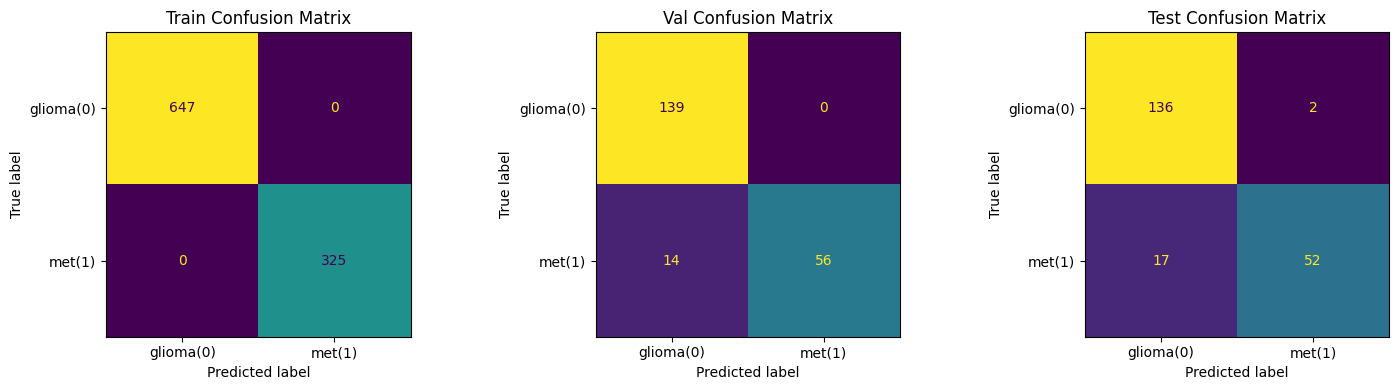

In [19]:
show_confusion_matrices()

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


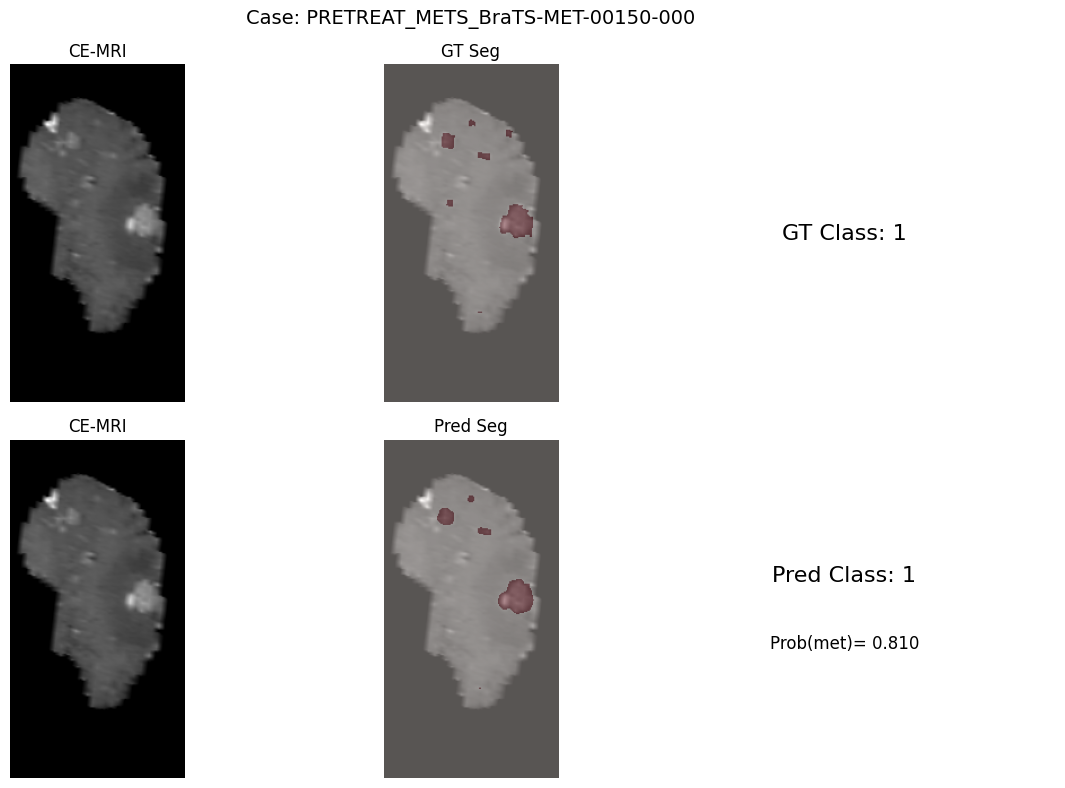

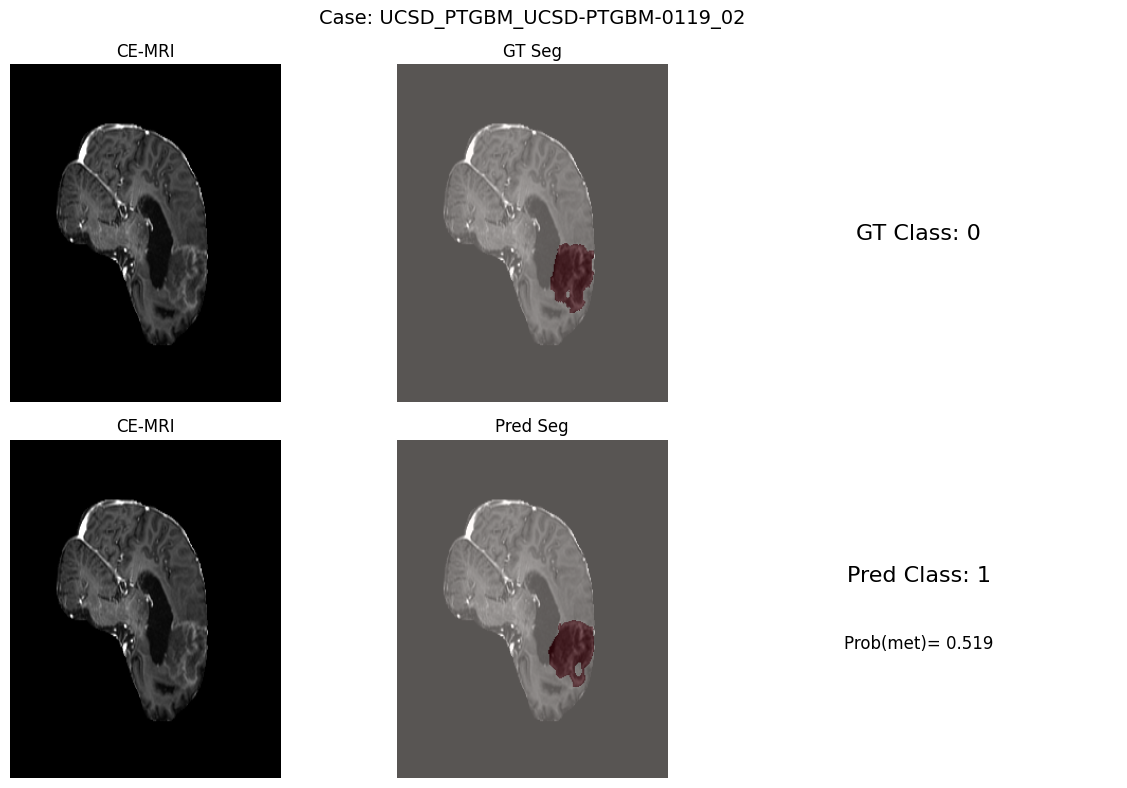

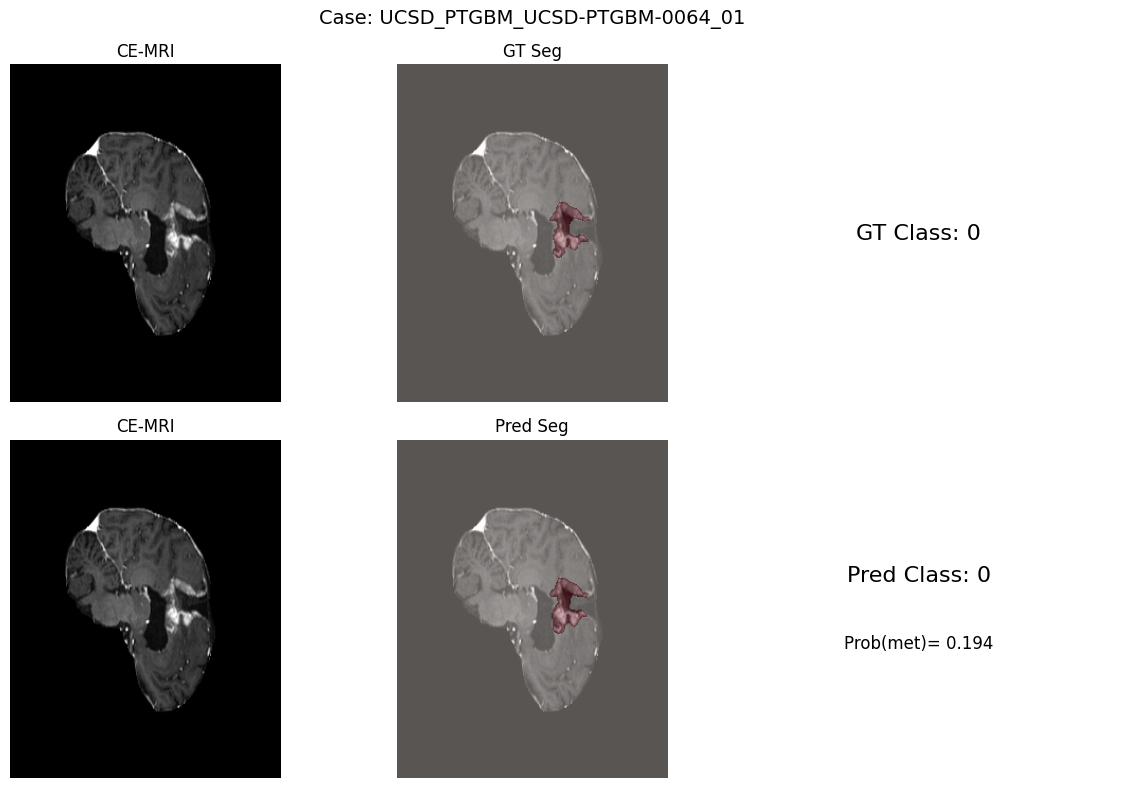

In [20]:
# # One random validation case
# show_random_case_grid(split="val")

# # One random training case
# show_random_case_grid(split="train")

# Three random test cases
for _ in range(3):
    show_random_case_grid(split="test")

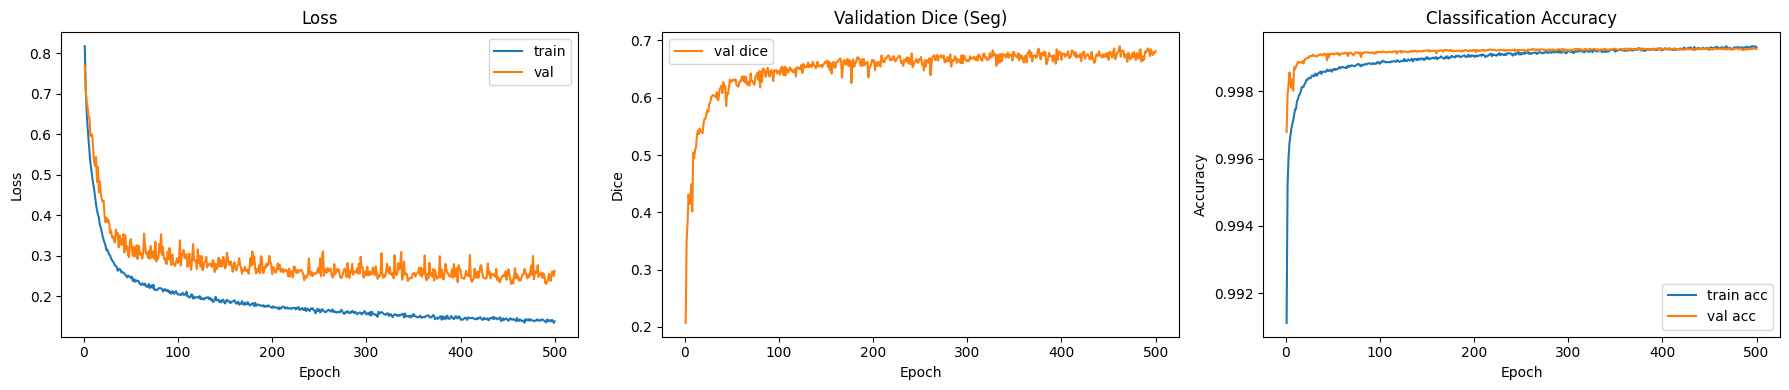

In [21]:
# Uses METRICS_CSV produced during training
plot_training_curves()

# If you saved a different metrics path:
# plot_training_curves(metrics_csv=RUN_DIR / "metrics.csv")

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


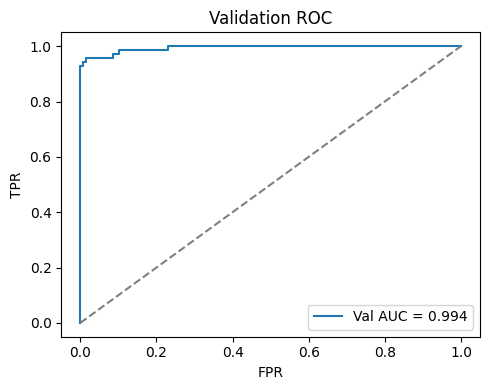

In [22]:
from sklearn.metrics import roc_curve, auc

# On validation set:
y_true, y_prob, y_pred = _run_cls_and_seg_on_loader(val_loader)
fpr, tpr, _ = roc_curve(y_true, y_prob)
val_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"Val AUC = {val_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Validation ROC"); plt.legend(); plt.tight_layout(); plt.show()

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


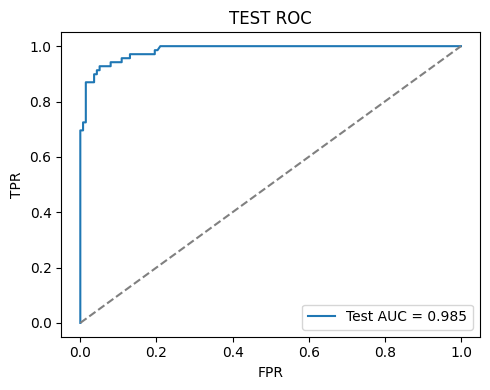

In [23]:
# On Test set:
y_true, y_prob, y_pred = _run_cls_and_seg_on_loader(test_loader)
fpr, tpr, _ = roc_curve(y_true, y_prob)
val_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"Test AUC = {val_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("TEST ROC"); plt.legend(); plt.tight_layout(); plt.show()

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


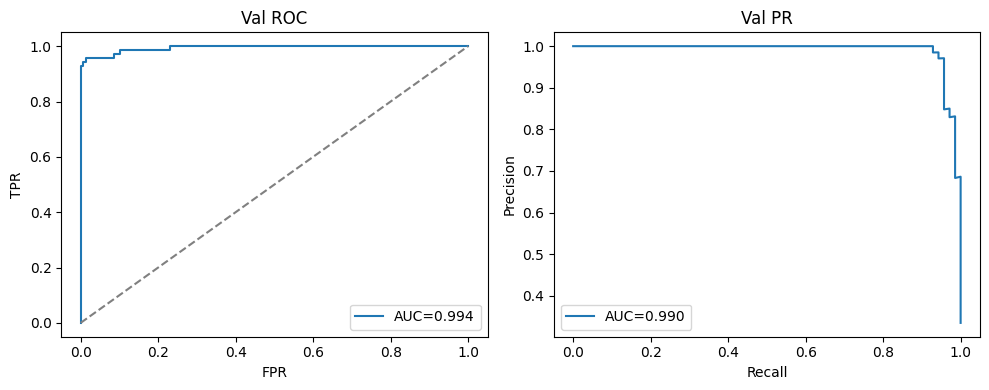

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


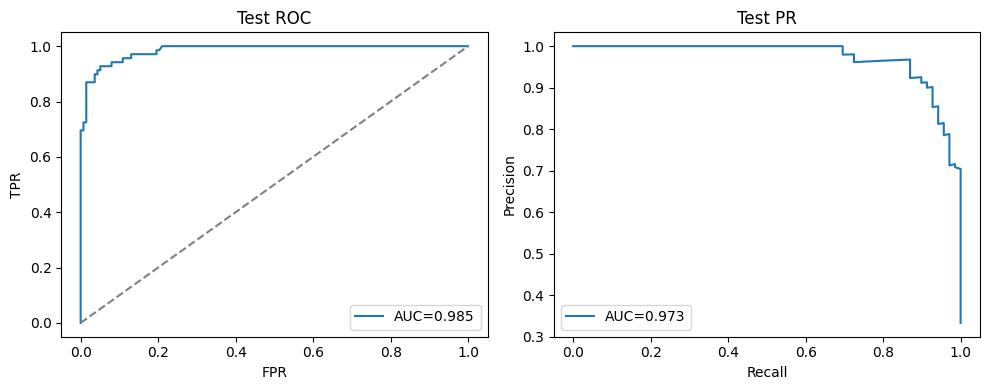

In [24]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def plot_roc_pr_curves():
    for name, loader in [("Val", val_loader), ("Test", test_loader)]:
        y_true, y_prob, _ = _run_cls_and_seg_on_loader(loader)
        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        # PR
        prec, rec, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(rec, prec)

        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        axes[0].plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
        axes[0].plot([0,1], [0,1], "--", color="gray")
        axes[0].set_title(f"{name} ROC"); axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR"); axes[0].legend()

        axes[1].plot(rec, prec, label=f"AUC={pr_auc:.3f}")
        axes[1].set_title(f"{name} PR"); axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision"); axes[1].legend()
        plt.tight_layout()
        plt.show()

plot_roc_pr_curves()

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


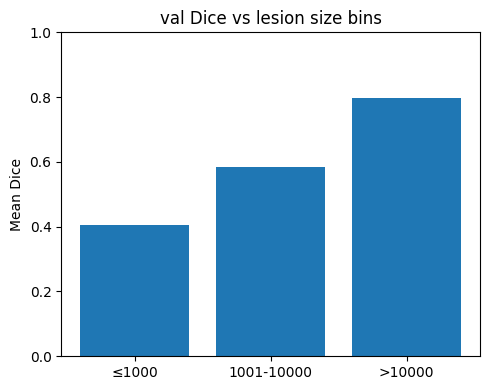

In [25]:
def dice_vs_size_bins(split="val", bins=(0, 1000, 10000, 1e9)):
    ds = {"train": train_loader, "val": val_loader, "test": test_loader}[split]
    seg_net.eval(); cls_head.eval()
    X_bins, dices = [], []
    with torch.no_grad():
        for batch in ds:
            batch = to_device(batch, device)
            images, labels = batch["image"], batch["label"].long()
            with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                images_p = pad_to_factor(images, factor=32)
                seg_logits = inferer(inputs=images_p, network=seg_net)
                if seg_logits.shape[-3:] != labels.shape[-3:]:
                    seg_logits = crop_to_shape(seg_logits, labels.shape[-3:])
                y_pred = torch.argmax(torch.softmax(seg_logits, dim=1), dim=1, keepdim=True)
            lab_np = labels[0,0].cpu().numpy()
            vol = int(lab_np.sum())
            # per-case Dice
            pred_np = y_pred[0,0].cpu().numpy()
            inter = (lab_np & pred_np).sum()
            d = (2*inter) / max(1, lab_np.sum() + pred_np.sum())
            bin_idx = np.digitize([vol], bins)[0]-1
            X_bins.append(bin_idx); dices.append(d)
    # aggregate
    means = []
    for b in range(len(bins)-1):
        arr = [d for x,d in zip(X_bins, dices) if x==b]
        means.append(np.mean(arr) if len(arr)>0 else np.nan)
    labels_bins = [f"≤{int(bins[1])}", f"{int(bins[1])+1}-{int(bins[2])}", f">{int(bins[2])}"]
    plt.figure(figsize=(5,4))
    plt.bar(labels_bins, means)
    plt.ylabel("Mean Dice"); plt.title(f"{split} Dice vs lesion size bins")
    plt.ylim(0,1); plt.tight_layout(); plt.show()

dice_vs_size_bins("val")

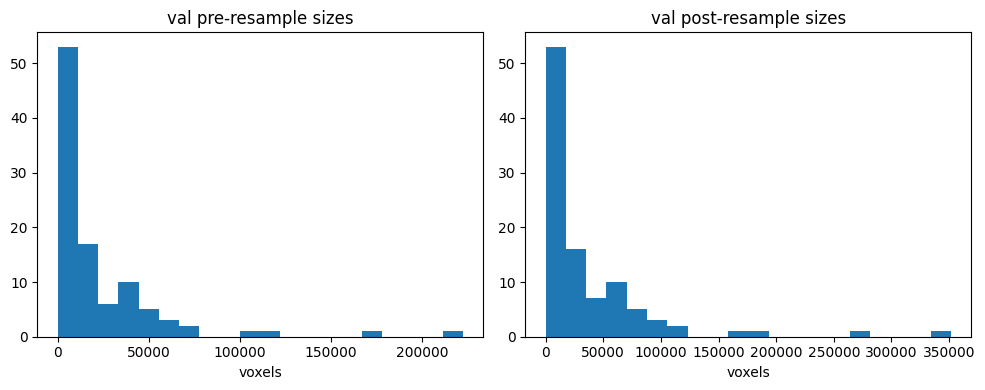

In [26]:
import nibabel as nib

def size_hist_pre_post(split="val", n=100):
    # sample up to n cases
    base_ds = {"train": train_loader.dataset, "val": val_loader.dataset, "test": test_loader.dataset}[split]
    items = base_ds.data if hasattr(base_ds, "data") else val_items
    sample = items[:min(n, len(items))]

    pre_counts, post_counts = [], []
    for it in sample:
        # pre (load raw file)
        lab_path = it["label"]
        arr = (nib.load(lab_path).get_fdata() > 0).astype(np.uint8)
        pre_counts.append(arr.sum())
        # post (apply transforms minimally)
        d = {"image": it["image"], "label": it["label"], "class_label": it["class_label"]}
        d = val_transforms(d)
        post_counts.append(int((d["label"]>0).sum().item()))

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(pre_counts, bins=20); plt.title(f"{split} pre-resample sizes"); plt.xlabel("voxels")
    plt.subplot(1,2,2); plt.hist(post_counts, bins=20); plt.title(f"{split} post-resample sizes"); plt.xlabel("voxels")
    plt.tight_layout(); plt.show()

size_hist_pre_post("val", n=100)

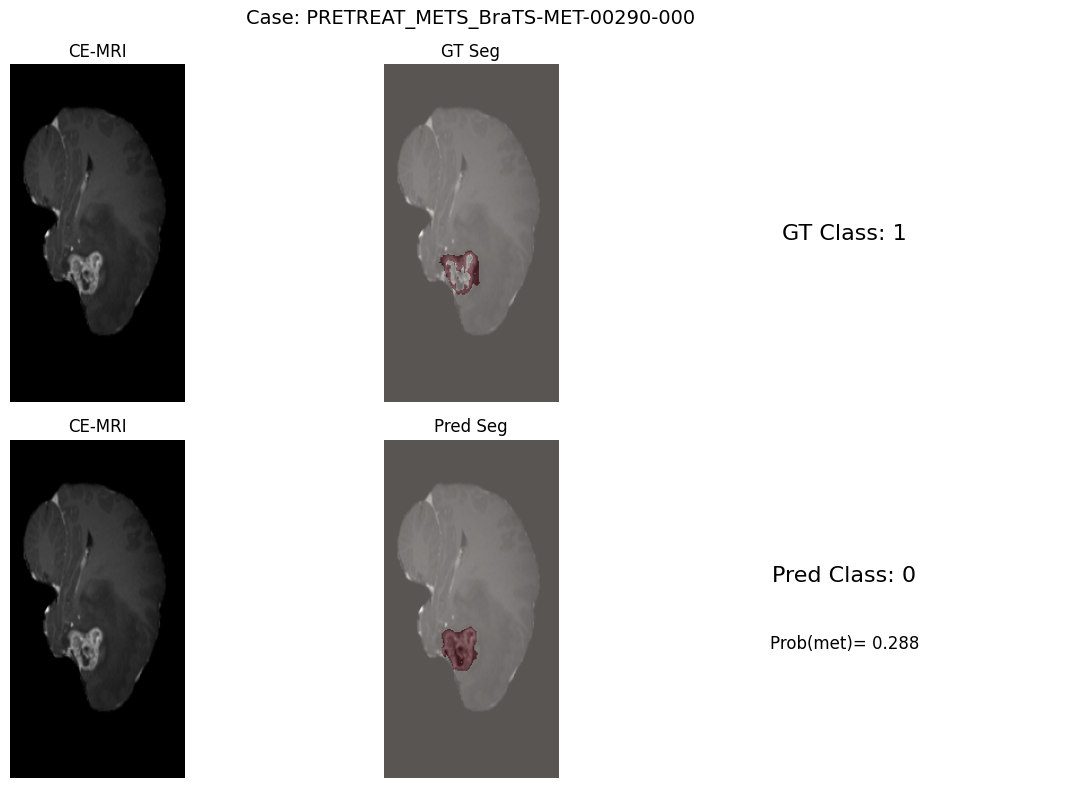

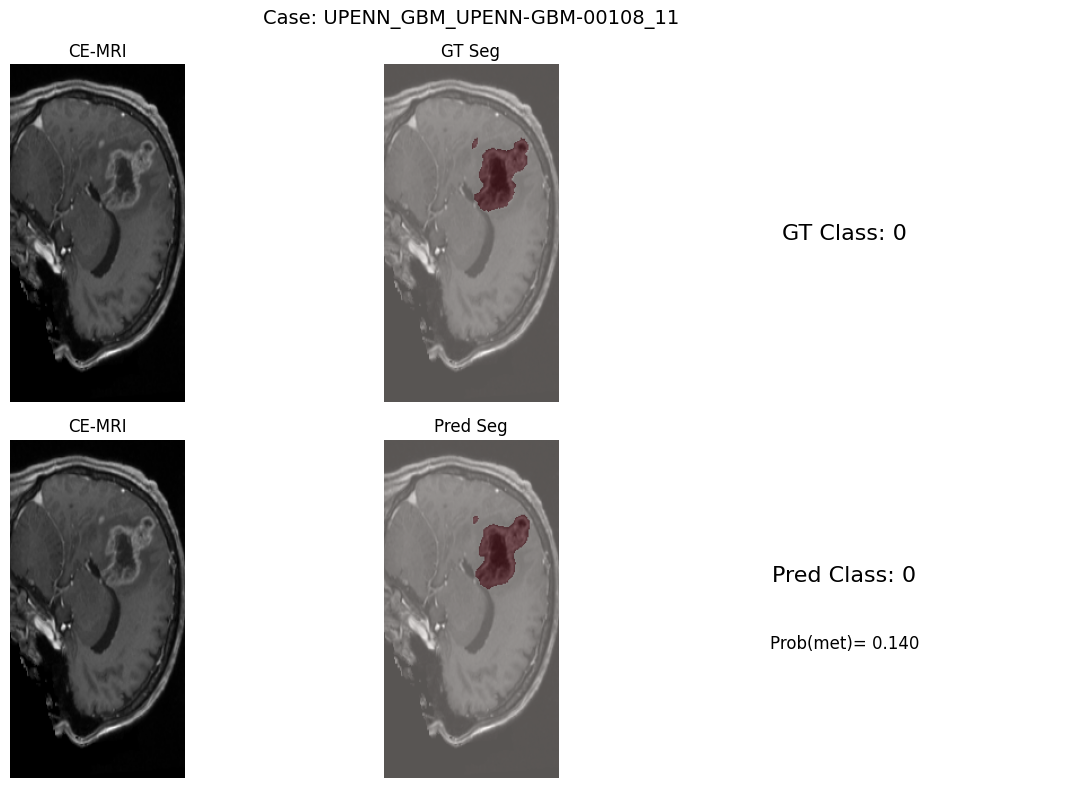

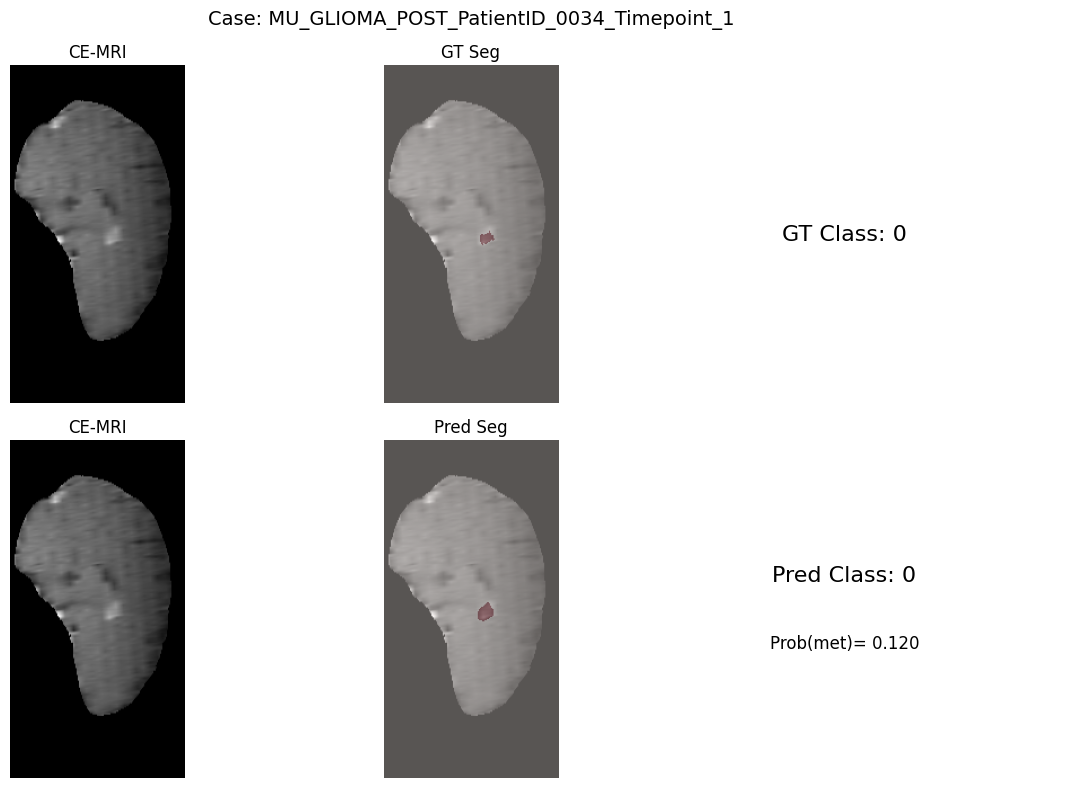

In [27]:
def show_montage(split="val", num=4):
    for _ in range(num):
        show_random_case_grid(split=split)

show_montage("val", num=3)

In [31]:
import gc, torch
for name in ["images","labels","seg_logits","cls_logits","feat","y_pred","images_p","batch"]:
    if name in globals(): 
        try: del globals()[name]
        except: pass
torch.cuda.empty_cache(); gc.collect(); torch.cuda.synchronize()

In [28]:
def show_worst_cases(split="val", k=3):
    ds = {"train": train_loader, "val": val_loader, "test": test_loader}[split]
    scores = []
    seg_net.eval(); cls_head.eval()
    with torch.no_grad():
        for batch in ds:
            batch = to_device(batch, device)
            images, labels = batch["image"], batch["label"].long()
            with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                images_p = pad_to_factor(images, factor=32)
                seg_logits = inferer(inputs=images_p, network=seg_net)
                if seg_logits.shape[-3:] != labels.shape[-3:]:
                    seg_logits = crop_to_shape(seg_logits, labels.shape[-3:])
                y_pred = torch.argmax(torch.softmax(seg_logits, dim=1), dim=1, keepdim=True)
            lab = labels[0,0].cpu().numpy(); pred = y_pred[0,0].cpu().numpy()
            inter = (lab & pred).sum()
            d = (2*inter)/max(1, lab.sum()+pred.sum())
            scores.append((d, batch))
    scores.sort(key=lambda x: x[0])  # lowest first
    for i in range(min(k, len(scores))):
        print(f"Worst {i+1}: Dice={scores[i][0]:.3f}")
        # visualize one slice
        b = scores[i][1]
        show_random_case_grid(split=split)  # reuse random grid; for exact case, you can adapt to pass batch
show_worst_cases("val", k=3)

Worst 1: Dice=0.000


OutOfMemoryError: CUDA out of memory. Tried to allocate 1000.00 MiB. GPU 0 has a total capacity of 47.41 GiB of which 91.75 MiB is free. Including non-PyTorch memory, this process has 46.22 GiB memory in use. Of the allocated memory 40.64 GiB is allocated by PyTorch, and 5.21 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def inference_summary(split="test", n=10):
    ds = {"train": train_loader, "val": val_loader, "test": test_loader}[split]
    times = []
    import time
    seg_params = sum(p.numel() for p in seg_net.parameters())
    cls_params = sum(p.numel() for p in cls_head.parameters())
    with torch.no_grad():
        for i, batch in enumerate(ds):
            if i>=n: break
            batch = to_device(batch, device)
            images = batch["image"]
            t0 = time.time()
            _ = sliding_infer_padded(images, seg_net, factor=32, target_shape=images.shape[-3:])
            times.append(time.time()-t0)
    print({
        "avg_seconds_per_volume": float(np.mean(times)) if times else None,
        "seg_num_params": seg_params,
        "cls_num_params": cls_params,
        "gpu": (torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
    })

inference_summary("test", n=10)